## Model: Dense Neural Network

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import math

pd.set_option('display.max_columns', None)

#### Loading the Dataframe

In [2]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)
    
df.columns = df.columns.str.lower()

In [3]:
df.head()

,discovery_doy,stat_cause_descr,state,source_system_type,duration,fire_size_class,latitude,longitude,source_reporting_unit_name,fire_year,fire_size,elevation,bdod,cec,cfvo,clay,nitrogen,phh2o,sand,silt,soc
1,133,Lightning,CA,FED,0.0,A,38.933056,-120.404444,Eldorado National Forest,2004,0.25,1842,102.0,335.0,246.0,140.0,466.0,58.0,550.0,309.0,741.0
2,152,Negligence,CA,FED,0.0,A,38.984167,-120.735556,Eldorado National Forest,2004,0.10,1067,119.0,213.0,137.0,244.0,343.0,58.0,331.0,425.0,573.0
3,180,Lightning,CA,FED,5.0,A,38.559167,-119.913333,Eldorado National Forest,2004,0.10,2365,110.0,129.0,216.0,66.0,201.0,55.0,755.0,179.0,458.0
4,180,Lightning,CA,FED,5.0,A,38.559167,-119.933056,Eldorado National Forest,2004,0.10,2316,118.0,137.0,212.0,68.0,156.0,55.0,740.0,192.0,410.0
5,182,Lightning,CA,FED,1.0,A,38.635278,-120.103611,Eldorado National Forest,2004,0.10,2541,108.0,204.0,230.0,66.0,283.0,55.0,697.0,237.0,509.0


In [4]:
df.shape

(52206, 21)

In [5]:
df['stat_cause_descr'].value_counts()

Lightning         19825
Negligence        13595
Infrastructure     9829
Arson              8957
Name: stat_cause_descr, dtype: int64

#### One-Hot Encoding

In [6]:
categorical = ['state','source_system_type']
numeric = ['discovery_doy','duration', 'latitude', 'longitude',
           'cec', 'cfvo', 'clay', 'phh2o', 'sand', 'silt', 'soc',           
           'bdod', 'nitrogen', 'fire_size', 'elevation', 'fire_year']

In [7]:
df_dum = pd.get_dummies(df[categorical],drop_first= True)
df_num = df[numeric]

#### Defining X and y

In [8]:
X = pd.concat([df_num,df_dum],axis=1)
y = df['stat_cause_descr'].map({'Lightning': 0, 'Negligence': 1, 'Infrastructure': 2, 'Arson': 3})

#### Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=2023)

#### Standard Scaling

In [10]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

#### Baseline

In [11]:
null_model = y.value_counts(normalize= True)
null_model

0    0.379746
1    0.260411
2    0.188273
3    0.171570
Name: stat_cause_descr, dtype: float64

In [12]:
model_rf = RandomForestClassifier()

In [13]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
params_rf = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'n_jobs': -1
}

In [15]:
#gs = GridSearchCV(model_rf,params_rf,cv=5)

In [16]:
#gs.fit(X_train,y_train)

In [17]:
best_params_rf = params_rf
best_params_rf

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_jobs': -1}

In [18]:
model_rf.set_params(**best_params_rf)

RandomForestClassifier(n_jobs=-1)

In [19]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [20]:
y_pred_rf = model_rf.predict(X_test)
score_rf = model_rf.score(X_test,y_test)
score_rf

# accuracy_rf = model_rf.score(X_test, y_test)
# precision_rf = precision_score(y_test_rf, y_pred)
# recall_rf = recall_score(y_test, y_pred_rf)
# f1_rf = f1_score(y_test, y_pred_rf)

0.7008235970120666

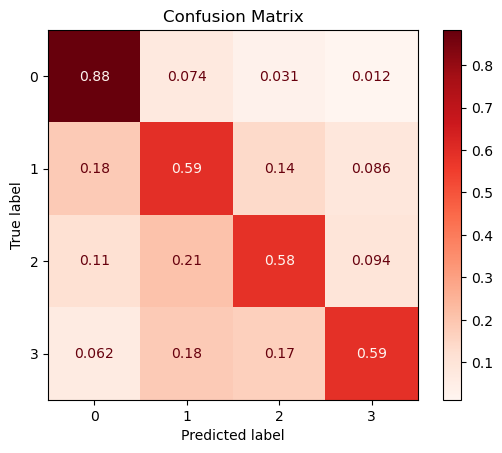

In [21]:
ConfusionMatrixDisplay.from_estimator(model_rf,X_test,y_test, cmap = 'Reds',normalize= 'true');
plt.title("Confusion Matrix");

### The Model

In [22]:
es = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

In [23]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

history = model.fit(
    Z_train,
    y_train,
    validation_data=(Z_test, y_test),
    epochs=70,
    batch_size=128,
    callbacks=[es]
)

Metal device set to: Apple M1 Max
Epoch 1/70


2023-03-23 19:43:18.264641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 19:43:18.264765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-23 19:43:18.431830: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 19:43:19.151813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - ETA: 0s - loss: 1.0913 - acc: 0.5577

2023-03-23 19:43:41.052031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - 24s 65ms/step - loss: 1.0913 - acc: 0.5577 - val_loss: 0.9270 - val_acc: 0.5989
Epoch 2/70
327/327 [==============================] - 7s 23ms/step - loss: 0.9482 - acc: 0.5987 - val_loss: 0.8905 - val_acc: 0.6271
Epoch 3/70
327/327 [==============================] - 7s 21ms/step - loss: 0.9211 - acc: 0.6142 - val_loss: 0.8810 - val_acc: 0.6382
Epoch 4/70
327/327 [==============================] - 6s 17ms/step - loss: 0.9088 - acc: 0.6223 - val_loss: 0.8744 - val_acc: 0.6386
Epoch 5/70
327/327 [==============================] - 5s 16ms/step - loss: 0.8971 - acc: 0.6266 - val_loss: 0.8664 - val_acc: 0.6426
Epoch 6/70
327/327 [==============================] - 5s 16ms/step - loss: 0.8904 - acc: 0.6270 - val_loss: 0.8738 - val_acc: 0.6471
Epoch 7/70
327/327 [==============================] - 5s 16ms/step - loss: 0.8839 - acc: 0.6337 - val_loss: 0.8739 - val_acc: 0.6412
Epoch 8/70
327/327 [==============================] - 5s 16ms/step - loss: 0.87

#### Best Model:

I tested and tweaked a number of parameters for this model. In the end these were my best parameters:
- Three dense layers of 512 nodes each
- Dropout of 0.4
- Batch Normalization of all layers
- Batch size of 128
- 200 epochs w/ early stopping

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               9728      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [25]:
model.evaluate(Z_test, y_test)

327/327 [==============================] - 2s 6ms/step - loss: 0.8097 - acc: 0.6705


[0.8097003698348999, 0.6704654097557068]

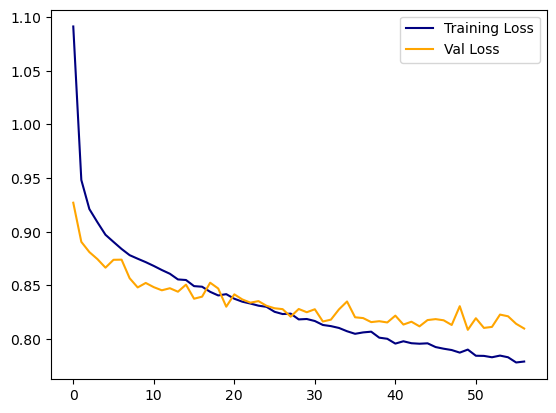

In [26]:
plt.plot(history.history['loss'], c='navy', label='Training Loss')
plt.plot(history.history['val_loss'], c='orange', label='Val Loss')
plt.legend();

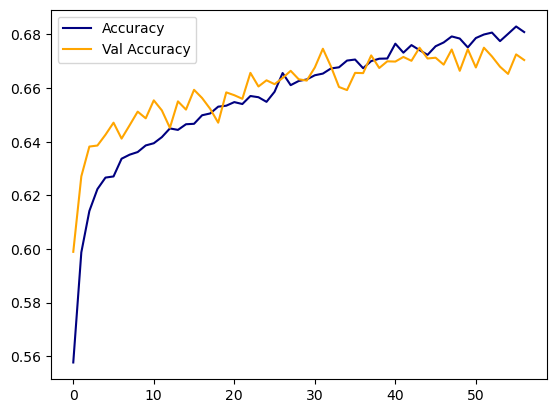

In [27]:
plt.plot(history.history['acc'], c='navy', label='Accuracy')
plt.plot(history.history['val_acc'], c='orange', label='Val Accuracy')
plt.legend();

In [28]:
y_preds = np.argmax(model.predict(Z_test), axis = 1)
y_preds

 35/327 [==>...........................] - ETA: 0s

2023-03-23 19:48:48.114176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - 1s 3ms/step


array([3, 0, 1, ..., 0, 2, 0])

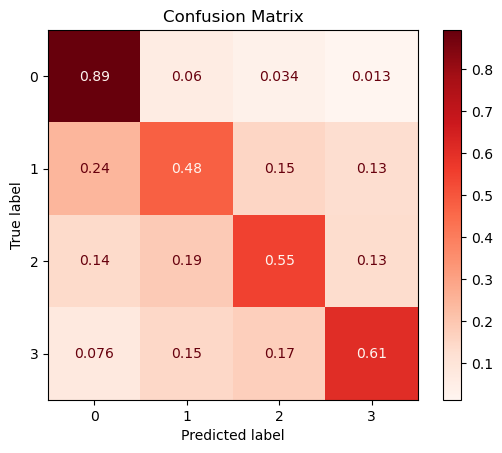

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds, normalize='true', cmap = 'Reds')
plt.title("Confusion Matrix");